# Proyecto 3 - Minería de datos
***Universidad del Valle de Guatemala***

___24 de marzo, 2025___

**Autores:**
- Daniel Alfredo Rayo Roldán
- Gerardo Pineda
- Juan Luis

# Introducción


# Situación Problemática

## Objetivos Generales

## Objetivos Específicos

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Descripción de los datos
Para iniciar el estudio se estrajeron las observaciones de divorcios hechas por el INE sobre el tema desde los años del 2013 hasta el 2023 (11 años). Se partió con un *dataset* con 76669 observaciones y 19 variables.

Se necesito hacer una cierta preprocesado, dado que las disposición y nombre de las variables cambio ligeramente a lo largo de los años, diferencias que se unificaron en las siguientes variables finales, con las que se trabajara a partir de ahora:

**Variables númericas:**

| Descripcion | Codificación | Categoría Nula |
|-----------------|-------|----|
| Edad del hombre | EDADHOM  | 999 |
| Edad de la mujer | EDADMUJ | 999 |

**Variables categóricas:**
| Descripcion | Codificación | Categoría Nula | 
|-----------------------------------|-------|---|
| Departamento de registro          | DEPREG |
| Municipio de registro             | MUPREG   |
| Mes de registro                   | MESREG   |
| Año de registro                   | AÑOREG   |
| Día de ocurrencia                 | DIAOCU |
| Mes de ocurrencia                 | MESOCU  |
| Año de ocurrencia                 | AÑOOCU |
| Departamento de ocurrencia        | DEPOCU |
| Municipio de ocurrencia           |  MUPOCU |
| Grupo étnico del hombre           | PUEHOM | 9 |
| Grupo étnico de la mujer          | PUEMUJ | 9 |
| Nacionalidad del hombre           | NACHOM | 9999 | 
| Nacionalidad de la mujer          | NACMUJ | 9999 |
| Escolaridad del hombre            | ESCHOM | 9 | 
| Escolaridad de la mujer           | ESCMUJ | 9 |
| Ocupación del hombre              | CIUOHOM | 99 | 
| Ocupación de la mujer             | CIUOMUJ | 99 |

***Nota:*** *La "categoría nula" para las variables en las que aplica, indica ese valor reservado para observaciones "sin definir", se podrían considerar como un equivalente del Nan.*


In [2]:
import pandas as pd
import glob

# Step 1: Get all CSV file paths
csv_files = glob.glob("data/*.CSV")

# Step 2: Define a generator to read and process each file on the fly
def read_and_clean(file):
    df = pd.read_csv(file)
    return df

# Step 3: Merge without storing copies
merged_df = pd.concat((read_and_clean(file) for file in csv_files), ignore_index=True)

numerical_var = ["EDADHOM", "EDADMUJ"]
categorical_var = [
    "DEPREG",
    "MUPREG",
    "MESREG",
    "AÑOREG",
    "DIAOCU",
    "MESOCU",
    "AÑOOCU",
    "DEPOCU",
    "MUPOCU",
    "PUEHOM", 
    "PUEMUJ", 
    "NACHOM", 
    "NACMUJ", 
    "ESCHOM", 
    "ESCMUJ", 
    "CIUOMUJ", 
    "CIUOHOM"]

In [4]:
DEPREG = {
    1: "Guatemala",
    2: "El Progreso",
    3: "Sacatepéquez",
    4: "Chimaltenango",
    5: "Escuintla",
    6: "Santa Rosa",
    7: "Sololá",
    8: "Totonicapán",
    9: "Quetzaltenango",
    10: "Suchitepéquez",
    11: "Retalhuleu",
    12: "San Marcos",
    13: "Huehuetenango",
    14: "Quiché",
    15: "Baja Verapaz",
    16: "Alta Verapaz",
    17: "Petén",
    18: "Izabal",
    19: "Zacapa",
    20: "Chiquimula",
    21: "Jalapa",
    22: "Jutiapa"
}

In [5]:
MUPREG = {
    "0101": "Guatemala",
    "0102": "Santa Catarina Pinula",
    "0103": "San José Pinula",
    "0104": "San José del Golfo",
    "0105": "Palencia",
    "0106": "Chinautla",
    "0107": "San Pedro Ayampuc",
    "0108": "Mixco",
    "0109": "San Pedro Sacatepéquez",
    "0110": "San Juan Sacatepéquez",
    "0111": "San Raymundo",
    "0112": "Chuarrancho",
    "0113": "Fraijanes",
    "0114": "Amatitlán",
    "0115": "Villa Nueva",
    "0116": "Villa Canales",
    "0117": "Petapa",
    "0201": "Guastatoya",
    "0202": "Morazán",
    "0203": "San Agustín Acasaguastlán",
    "0204": "San Cristóbal Acasaguastlán",
    "0205": "El Jícaro",
    "0206": "Sansare",
    "0207": "Sanarate",
    "0208": "San Antonio la Paz",
    "0301": "Antigua Guatemala",
    "0302": "Jocotenango",
    "0303": "Pastores",
    "0304": "Sumpango",
    "0305": "Santo Domingo Xenacoj",
    "0306": "Santiago Sacatepéquez",
    "0307": "San Bartolomé Milpas Altas",
    "0308": "San Lucas Sacatepéquez",
    "0309": "Santa Lucía Milpas Altas",
    "0310": "Magdalena Milpas Altas",
    "0311": "Santa María de Jesús",
    "0312": "Ciudad Vieja",
    "0313": "San Miguel Dueñas",
    "0314": "Alotenango",
    "0315": "San Antonio Aguas Calientes",
    "0316": "Santa Catarina Barahona",
    "0401": "Chimaltenango",
    "0402": "San José Poaquil",
    "0403": "San Martín Jilotepeque",
    "0404": "Comalapa",
    "0405": "Santa Apolonia",
    "0406": "Tecpán Guatemala",
    "0407": "Patzún",
    "0408": "Pochuta",
    "0409": "Patzicía",
    "0410": "Santa Cruz Balanyá",
    "0411": "Acatenango",
    "0412": "Yepocapa",
    "0413": "San Andrés Itzapa",
    "0414": "Parramos",
    "0415": "Zaragoza",
    "0416": "El Tejar",
    "0501": "Escuintla",
    "0502": "Santa Lucía Cotzumalguapa",
    "0503": "La Democracia",
    "0504": "Siquinalá",
    "0505": "Masagua",
    "0506": "Tiquisate",
    "0507": "La Gomera",
    "0508": "Guanagazapa",
    "0509": "San José",
    "0510": "Iztapa",
    "0511": "Palín",
    "0512": "San Vicente Pacaya",
    "0513": "Nueva Concepción",
    "0514": "Sipacate",
    "0601": "Cuilapa",
    "0602": "Barberena",
    "0603": "Santa Rosa de Lima",
    "0604": "Casillas",
    "0605": "San Rafael las Flores",
    "0606": "Oratorio",
    "0607": "San Juan Tecuaco",
    "0608": "Chiquimulilla",
    "0609": "Taxisco",
    "0610": "Santa María Ixhuatán",
    "0611": "Guazacapán",
    "0612": "Santa Cruz Naranjo",
    "0613": "Pueblo Nuevo Viñas",
    "0614": "Nueva Santa Rosa",
    "0701": "Sololá",
    "0702": "San José Chacayá",
    "0703": "Santa María Visitación",
    "0704": "Santa Lucía Utatlán",
    "0705": "Nahualá",
    "0706": "Santa Catarina Ixtahuacán",
    "0707": "Santa Clara la Laguna",
    "0708": "Concepción",
    "0709": "San Andrés Semetabaj",
    "0710": "Panajachel",
    "0711": "Santa Catarina Palopó",
    "0712": "San Antonio Palopó",
    "0713": "San Lucas Tolimán",
    "0714": "Santa Cruz la Laguna",
    "0715": "San Pablo la Laguna",
    "0716": "San Marcos la Laguna",
    "0717": "San Juan la Laguna",
    "0718": "San Pedro la Laguna",
    "0719": "Santiago Atitlán",
    "0801": "Totonicapán",
    "0802": "San Cristóbal Totonicapán",
    "0803": "San Francisco el Alto",
    "0804": "San Andrés Xecul",
    "0805": "Momostenango",
    "0806": "Santa María Chiquimula",
    "0807": "Santa Lucía la Reforma",
    "0808": "San Bartolo",
    "0901": "Quetzaltenango",
    "0902": "Salcajá",
    "0903": "Olintepeque",
    "0904": "San Carlos Sija",
    "0905": "Sibilia",
    "0906": "Cabricán",
    "0907": "Cajolá",
    "0908": "San Miguel Siguilá",
    "0909": "Ostuncalco",
    "0910": "San Mateo",
    "0911": "Concepción Chiquirichapa",
    "0912": "San Martín Sacatepéquez",
    "0913": "Almolonga",
    "0914": "Cantel",
    "0915": "Huitán",
    "0916": "Zunil",
    "0917": "Colomba",
    "0918": "San Francisco la Unión",
    "0919": "El Palmar",
    "0920": "Coatepeque",
    "0921": "Génova",
    "0922": "Flores Costa Cuca",
    "0923": "La Esperanza",
    "0924": "Palestina de los Altos",
    "1001": "Mazatenango",
    "1002": "Cuyotenango",
    "1003": "San Francisco Zapotitlán",
    "1004": "San Bernardino",
    "1005": "San José el Idolo",
    "1006": "Santo Domingo Suchitepéquez",
    "1007": "San Lorenzo",
    "1008": "Samayac",
    "1009": "San Pablo Jocopilas",
    "1010": "San Antonio Suchitepéquez",
    "1011": "San Miguel Panán",
    "1012": "San Gabriel",
    "1013": "Chicacao",
    "1014": "Patulul",
    "1015": "Santa Bárbara",
    "1016": "San Juan Bautista",
    "1017": "Santo Tomás la Unión",
    "1018": "Zunilito",
    "1019": "Pueblo Nuevo",
    "1020": "Río Bravo",
    "1021": "San José La Máquina",
    "1101": "Retalhuleu",
    "1102": "San Sebastián",
    "1103": "Santa Cruz Muluá",
    "1104": "San Martín Zapotitlán",
    "1105": "San Felipe",
    "1106": "San Andrés Villa Seca",
    "1107": "Champerico",
    "1108": "Nuevo San Carlos",
    "1109": "El Asintal",
    "1201": "San Marcos",
    "1202": "San Pedro Sacatepéquez",
    "1203": "San Antonio Sacatepéquez",
    "1204": "Comitancillo",
    "1205": "San Miguel Ixtahuacán",
    "1206": "Concepción Tutuapa",
    "1207": "Tacaná",
    "1208": "Sibinal",
    "1209": "Tajumulco",
    "1210": "Tejutla",
    "1211": "San Rafael Pié de la Cuesta",
    "1212": "Nuevo Progreso",
    "1213": "El Tumbador",
    "1214": "El Rodeo",
    "1215": "Malacatán",
    "1216": "Catarina",
    "1217": "Ayutla",
    "1218": "Ocós",
    "1219": "San Pablo",
    "1220": "El Quetzal",
    "1221": "La Reforma",
    "1222": "Pajapita",
    "1223": "Ixchiguán",
    "1224": "San José Ojetenán",
    "1225": "San Cristóbal Cucho",
    "1226": "Sipacapa",
    "1227": "Esquipulas Palo Gordo",
    "1228": "Río Blanco",
    "1229": "San Lorenzo",
    "1230": "La Blanca",
    "1301": "Huehuetenango",
    "1302": "Chiantla",
    "1303": "Malacatancito",
    "1304": "Cuilco",
    "1305": "Nentón",
    "1306": "San Pedro Necta",
    "1307": "Jacaltenango",
    "1308": "Soloma",
    "1309": "Ixtahuacán",
    "1310": "Santa Bárbara",
    "1311": "La Libertad",
    "1312": "La Democracia",
    "1313": "San Miguel Acatán",
    "1314": "San Rafael la Independencia",
    "1315": "Todos Santos Cuchumatán",
    "1316": "San Juan Atitán",
    "1317": "Santa Eulalia",
    "1318": "San Mateo Ixtatán",
    "1319": "Colotenango",
    "1320": "San Sebastián Huehuetenango",
    "1321": "Tectitán",
    "1322": "Concepción Huista",
    "1323": "San Juan Ixcoy",
    "1324": "San Antonio Huista",
    "1325": "San Sebastián Coatán",
    "1326": "Barillas",
    "1327": "Aguacatán",
    "1328": "San Rafael Petzal",
    "1329": "San Gaspar Ixchil",
    "1330": "Santiago Chimaltenango",
    "1331": "Santa Ana Huista",
    "1332": "Unión Cantinil",
    "1333": "Petatán",
    "1401": "Santa Cruz del Quiché",
    "1402": "Chiché",
    "1403": "Chinique",
    "1404": "Zacualpa",
    "1405": "Chajul",
    "1406": "Chichicastenango",
    "1407": "Patzité",
    "1408": "San Antonio Ilotenango",
    "1409": "San Pedro Jocopilas",
    "1410": "Cunén",
    "1411": "San Juan Cotzal",
    "1412": "Joyabaj",
    "1413": "Nebaj",
    "1414": "San Andrés Sajcabajá",
    "1415": "Uspantán",
    "1416": "Sacapulas",
    "1417": "San Bartolomé Jocotenango",
    "1418": "Canillá",
    "1419": "Chicamán",
    "1420": "Ixcán",
    "1421": "Pachalum",
    "1501": "Salamá",
    "1502": "San Miguel Chicaj",
    "1503": "Rabinal",
    "1504": "Cubulco",
    "1505": "Granados",
    "1506": "El Chol",
    "1507": "San Jerónimo",
    "1508": "Purulhá",
    "1601": "Cobán",
    "1602": "Santa Cruz Verapaz",
    "1603": "San Cristóbal Verapaz",
    "1604": "Tactic",
    "1605": "Tamahú",
    "1606": "Tucurú",
    "1607": "Panzós",
    "1608": "Senahú",
    "1609": "San Pedro Carchá",
    "1610": "San Juan Chamelco",
    "1611": "Lanquín",
    "1612": "Cahabón",
    "1613": "Chisec",
    "1614": "Chahal",
    "1615": "Fray Bartolomé de las Casas",
    "1616": "Santa Catalina la Tinta",
    "1617": "Raxruhá",
    "1701": "Flores",
    "1702": "San José",
    "1703": "San Benito",
    "1704": "San Andrés",
    "1705": "La Libertad",
    "1706": "San Francisco",
    "1707": "Santa Ana",
    "1708": "Dolores",
    "1709": "San Luis",
    "1710": "Sayaxché",
    "1711": "Melchor de Mencos",
    "1712": "Poptún",
    "1713": "Las Cruces",
    "1714": "El Chal",
    "1801": "Puerto Barrios",
    "1802": "Livingston",
    "1803": "El Estor",
    "1804": "Morales",
    "1805": "Los Amates",
    "1901": "Zacapa",
    "1902": "Estanzuela",
    "1903": "Río Hondo",
    "1904": "Gualán",
    "1905": "Teculután",
    "1906": "Usumatlán",
    "1907": "Cabañas",
    "1908": "San Diego",
    "1909": "La Unión",
    "1910": "Huité",
    "1911": "San Jorge",
    "2001": "Chiquimula",
    "2002": "San José La Arada",
    "2003": "San Juan Ermita",
    "2004": "Jocotán",
    "2005": "Camotán",
    "2006": "Olopa",
    "2007": "Esquipulas",
    "2008": "Concepción Las Minas",
    "2009": "Quetzaltepeque",
    "2010": "San Jacinto",
    "2011": "Ipala",
    "2101": "Jalapa",
    "2102": "San Pedro Pinula",
    "2103": "San Luis Jilotepeque",
    "2104": "San Manuel Chaparrón",
    "2105": "San Carlos Alzatate",
    "2106": "Monjas",
    "2107": "Mataquescuintla",
    "2201": "Jutiapa",
    "2202": "El Progreso",
    "2203": "Santa Catarina Mita",
    "2204": "Agua Blanca",
    "2205": "Asunción Mita",
    "2206": "Yupiltepeque",
    "2207": "Atescatempa",
    "2208": "Jerez",
    "2209": "El Adelanto",
    "2210": "Zapotitlán",
    "2211": "Comapa",
    "2212": "Jalpatagua",
    "2213": "Conguaco",
    "2214": "Moyuta",
    "2215": "Pasaco",
    "2216": "San José Acatempa",
    "2217": "Quesada"
}

In [6]:
MESREG = {
    1: "Enero",
    2: "Febrero",
    3: "Marzo",
    4: "Abril",
    5: "Mayo",
    6: "Junio",
    7: "Julio",
    8: "Agosto",
    9: "Septiembre",
    10: "Octubre",
    11: "Noviembre",
    12: "Diciembre"
}

In [7]:
MESOCU = MESREG

In [8]:
DEPOCU = DEPREG

In [9]:
MUPOCU = MUPREG

In [10]:
PUEHOM = PUEMUJ = {
    1: "Maya",
    2: "Garífuna",
    3: "Xinka",
    4: "Mestizo / Ladino",
    5: "Otro",
    9: "Ignorado"
}

In [11]:
ESCHOM = ESCMUJ = {
    1: "Ninguno",
    2: "Primaria",
    3: "Básica",
    4: "Diversificado",
    5: "Universitario",
    6: "Postgrado",
    9: "Ignorado"
}

In [15]:
ocupationsExcel = pd.read_excel('./data/Ocupaciones.xls')
CIUOHOM = CIUOMUJ = dict(zip(ocupationsExcel.iloc[:, 0], ocupationsExcel.iloc[:, 1]))
del ocupationsExcel

## Análisis de variables
Con la base de datos preparada, se procedio a inspeccionar las caracteristicas y frencuencias de las diferentes variables con el fin de determinar si algunas podrian ser descartadas o simplificadas debido a la poca información que ofrecen.

Sin embargo, es primero importante describir la distribución de datos nulos en cada uno de las variables: 

In [16]:
df_null_values = merged_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]
null_values = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "NACHOM": 9999,
    "NACMUJ": 9999,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(merged_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
total_rows = len(merged_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

,Variable,Frecuencia de valores nulos,% de valores nulos
0,EDADHOM,34573,45.1
1,EDADMUJ,34521,45.0
2,PUEHOM,37606,49.0
3,PUEMUJ,37726,49.2
4,NACHOM,298,0.4
5,NACMUJ,306,0.4
6,ESCHOM,33234,43.3
7,ESCMUJ,32856,42.9
8,CIUOMUJ,23712,30.9
9,CIUOHOM,19831,25.9


Se puede observar que en todas las variables donde hay posibilidad de haber datos nulos, hay un porcentaje considerable, siendo en los menores las variables de *Nacionalidad*, y las mayores las variables de *Grupo étnico*. Para el tratamiento de dichas se hicieron los siguientes tratamientos:
- Remoción de filas que presentaban datos atípicos en cualquiera de las variables

In [17]:
# 1. REMOCION DE DATOS ATIPICOS
def remove_outliers(dataframe):
    '''
    return a dataframe without rows that are outliers in any column
    '''
    return dataframe\
    .loc[:, lambda df: df.std() > 0.04]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]
    
merged_df = remove_outliers(merged_df)

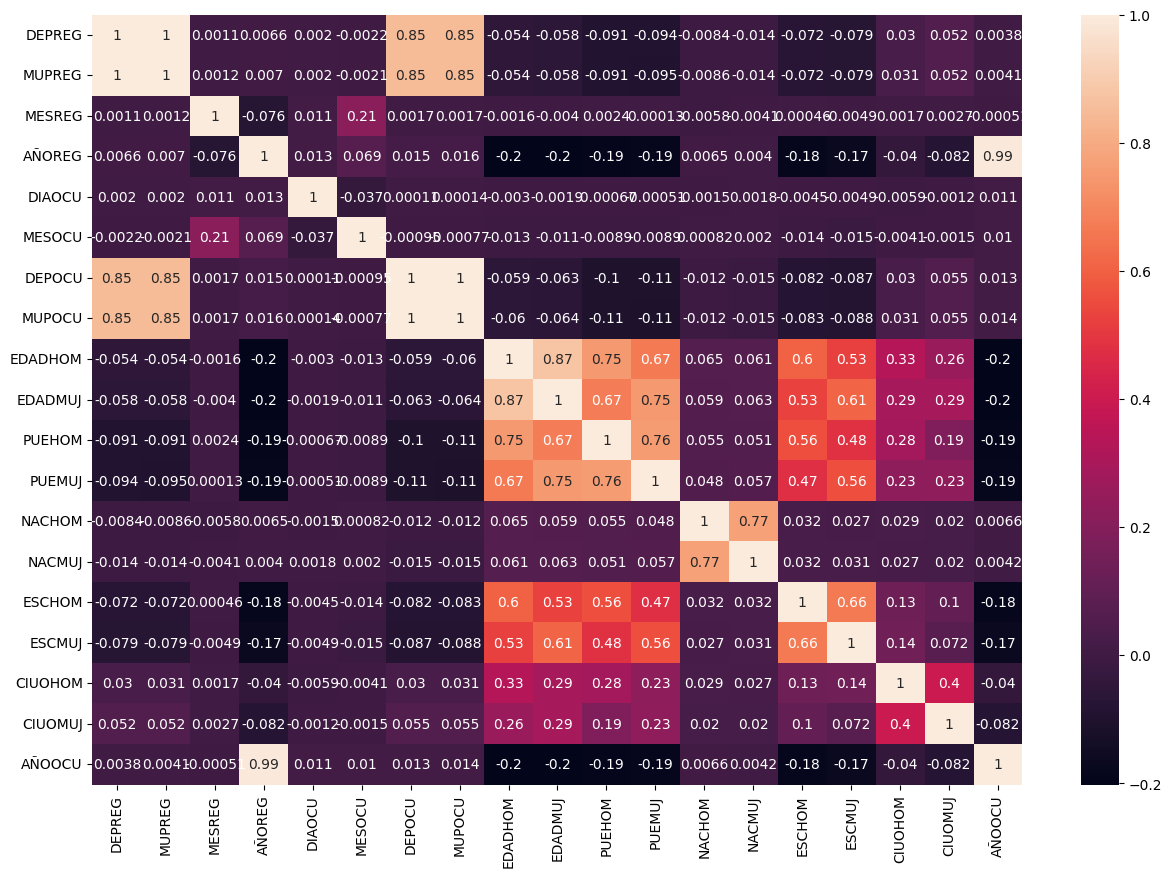

In [ ]:
# 2. 
corr = merged_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, annot=True, )
%matplotlib inline

(76669, 19)
(76291, 19)


**Variables cuantitativas:**
En este dataset solo se cuenta con 2 variables númericas que indican la edad de la pareja que se divorcio en cuestión. Ignorando los datos nulos, la distribución de los 

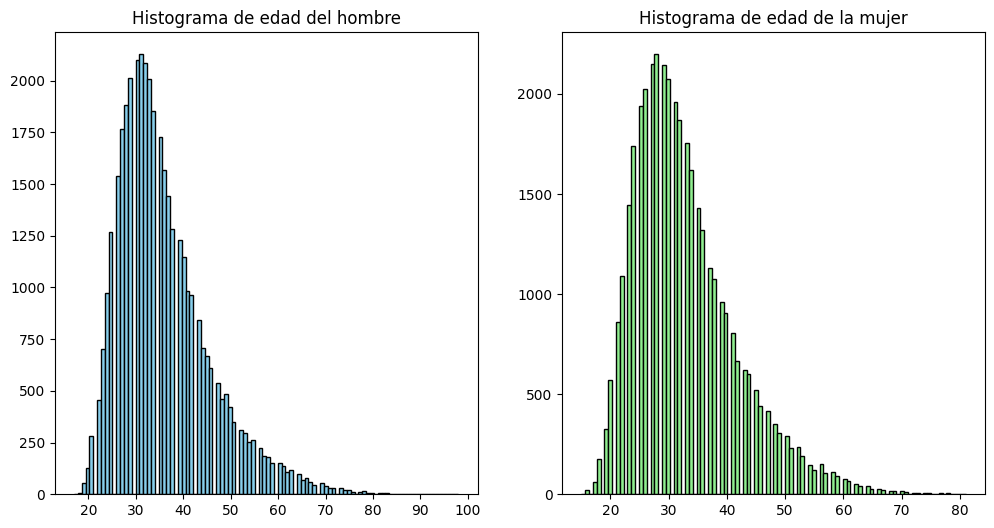

In [18]:
df_filtered = merged_df[(merged_df['EDADHOM'] != 999) & (merged_df['EDADMUJ'] != 999)]
# Plotting histograms
plt.figure(figsize=(12, 6))

# Plotting variable_1
plt.subplot(1, 2, 1)  # (rows, columns, position)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histograma de edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Histograma de edad de la mujer')
%matplotlib inline

# Análisis exploratorio

## Variables cuantitativas

## Variables cualitativas

## Preguntas exploratorias

### ¿Cuál es la tendencia del número de divorcios por año entre 2013 y 2023?

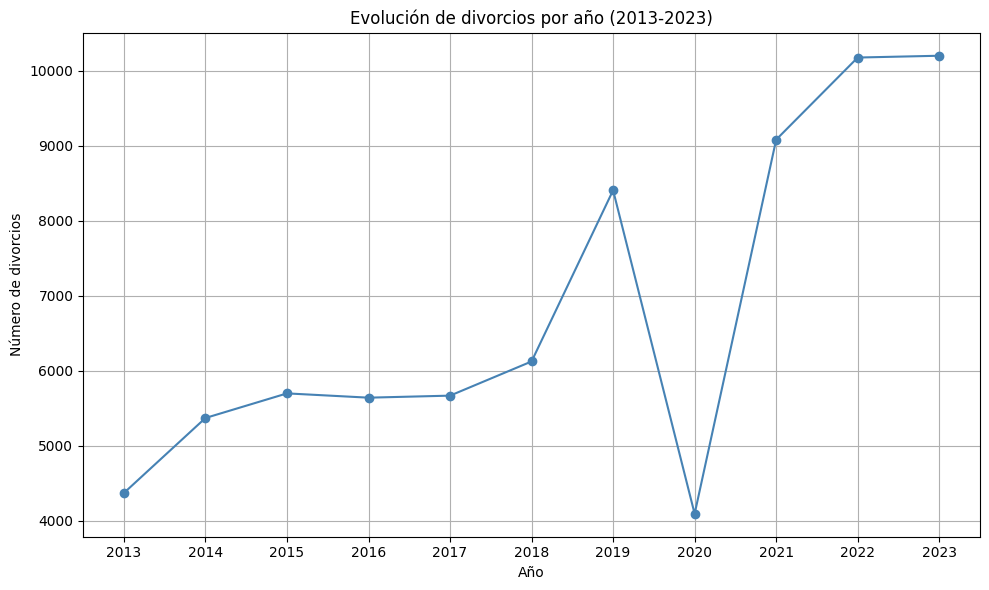

In [ ]:
# Contar el número de divorcios por año
divorcios_por_año = merged_df["AÑOREG"].value_counts().sort_index()

divorcios_por_año = divorcios_por_año.loc[2013:2023]

plt.figure(figsize=(10, 6))
divorcios_por_año.plot(kind='line', marker='o', color='steelblue')
plt.title("Evolución de divorcios por año (2013-2023)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True)
plt.xticks(range(2013, 2024))
plt.tight_layout()
plt.show()

Como se puede observar el gráfico, el número de divorcios en Guatemala presenta una tendencia creciente con variaciones notables a lo largo del tiempo. Entre 2013 y 2018, se observa un crecimiento moderado y relativamente estable. Sin embargo, en 2019 se registra un incremento abrupto, marcando un cambio significativo respecto a los años anteriores.

En 2020, se evidencia una caída pronunciada, probablemente relacionada con la pandemia de COVID-19, que limitó el acceso a los procesos legales y a las instituciones encargadas de tramitar divorcios. Muchas personas estuvieron confinadas, lo que dificultó llevar a cabo estos procedimientos.

A partir de 2021 y hasta 2023, se retoma la tendencia creciente, con un aumento considerable en el número de divorcios. Este repunte puede atribuirse a que, durante la pandemia, la convivencia forzada y el estrés provocaron tensiones en muchas parejas, las cuales derivaron en rupturas formales una vez reanudadas las actividades tras el COVID-19.

### ¿En qué meses se registran más divorcios? ¿Existe alguna estacionalidad?

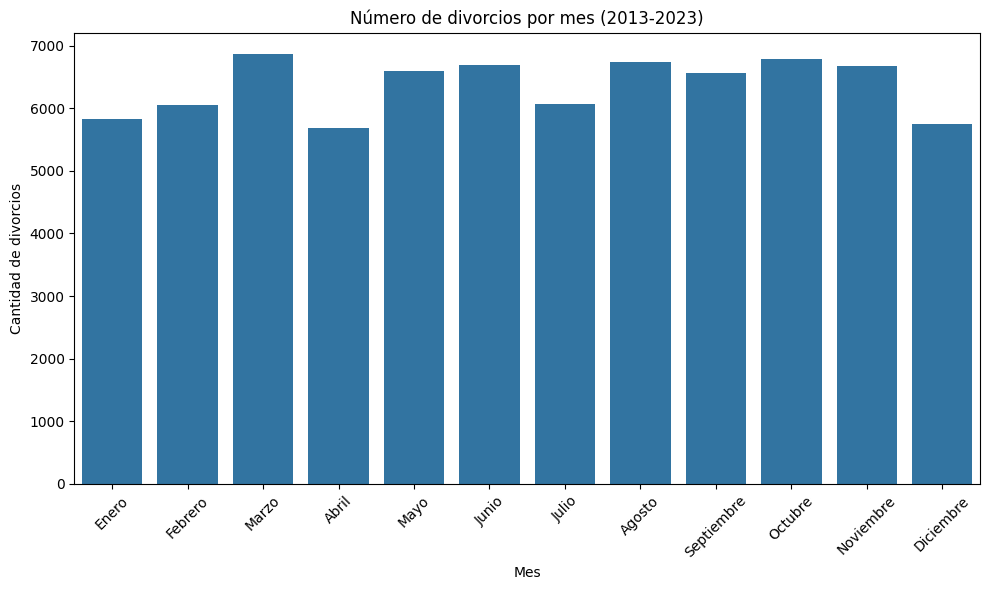

In [ ]:
divorcios_por_mes = merged_df['MESREG'].value_counts().sort_index()

meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
         'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
divorcios_por_mes.index = [meses[i-1] for i in divorcios_por_mes.index]

plt.figure(figsize=(10, 6))
sns.barplot(x=divorcios_por_mes.index, y=divorcios_por_mes.values)
plt.xticks(rotation=45)
plt.title("Número de divorcios por mes (2013-2023)")
plt.xlabel("Mes")
plt.ylabel("Cantidad de divorcios")
plt.tight_layout()
plt.show()

Se puede observar que a lo largo del año existe una tendencia cíclica en la frecuencia de divorcios, caracterizada por incrementos sostenidos durante tres meses seguidos, seguidos por una ligera caída. Esto permite identificar ciertos "bloques" o periodos:

1. Enero - Marzo
2. Abril - Junio
3. Julio - Septiembre

Cada uno de estos muestra una dinámica de crecimiento o estabilidad. Sin embargo, el último trimestre del año (octubre a diciembre) rompe con esta regularidad. En este periodo se observa un comportamiento atípico: los divorcios inician en niveles altos en octubre y descienden progresivamente hasta diciembre.

Este fenómeno podría deberse a varios factores contextuales. Por ejemplo, la cercanía de las festividades de fin de año, como Navidad y Año Nuevo, podría generar una disminución en la intención o posibilidad de concretar un divorcio, ya sea por motivos emocionales, familiares o incluso por cuestiones logísticas como cierres administrativos de procesos.

### ¿Cuál es el Departamento de Guatemala con mas divorcios reportados?

In [ ]:
# Contar divorcios por departamento directamente
divorcios_por_departamento = merged_df['DEPOCU'].map(DEPREG).value_counts().sort_values(ascending=False)

divorcios_por_departamento.T


DEPOCU
Guatemala         27622
Quetzaltenango     5886
Escuintla          3782
San Marcos         3467
Jutiapa            3260
Suchitepéquez      2824
Huehuetenango      2763
Izabal             2433
Retalhuleu         2278
Santa Rosa         2212
Quiché             2205
Petén              2076
Chiquimula         1922
Zacapa             1794
Chimaltenango      1690
Jalapa             1668
Sacatepéquez       1631
Alta Verapaz       1604
Baja Verapaz       1476
Totonicapán        1415
El Progreso        1363
Sololá              920
Name: count, dtype: int64

Este resultado tiene bastante sentido debido a que la mayor parte de la población guatemalteca esta concentrada en la capital. Siendo el deparatemto con mayor frecuencia de divorcios.


### ¿Cuál es la distribución de edades de los hombres y mujeres al momento del divorcio?

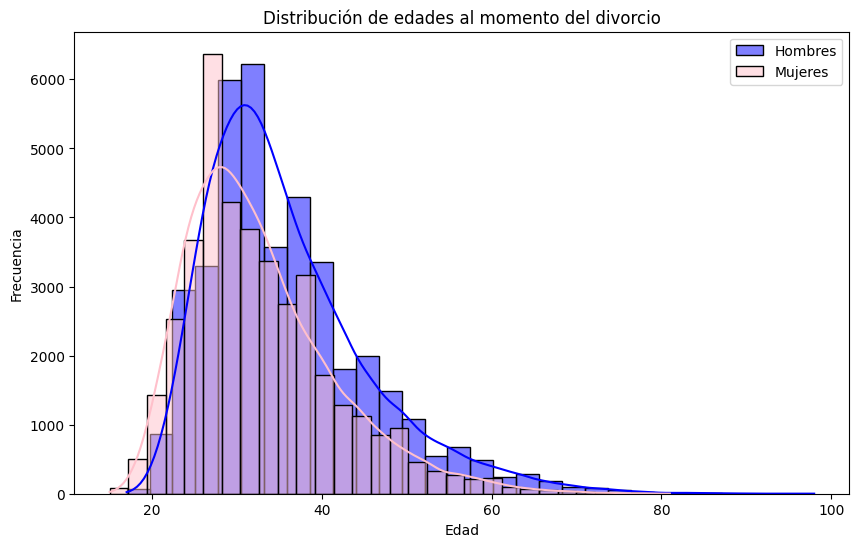

In [ ]:
df_filtrado =  merged_df[(merged_df['EDADHOM'] != 999) & (merged_df['EDADMUJ'] != 999)]

plt.figure(figsize=(10, 6))
sns.histplot(df_filtrado['EDADHOM'], kde=True, color='blue', label='Hombres', bins=30)
sns.histplot(df_filtrado['EDADMUJ'], kde=True, color='pink', label='Mujeres', bins=30)
plt.title("Distribución de edades al momento del divorcio")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


La gráfica muestra una distribución con sesgo hacia la derecha, lo que indica que, si bien la mayoría de los divorcios ocurre en edades tempranas, también hay casos que se presentan incluso después de los 60 años. La mayor concentración de divorcios tanto en hombres como en mujeres se sitúa entre los 20 y 40 años.

Además, se puede notar que las mujeres tienden a divorciarse a una edad más temprana que los hombres, especialmente entre los 25 y 30 años. Esta diferencia podria deberse a factores sociales comunes como hombres de mayor edad casandose con muejeres mas jovenes, o también podría estar relacionada con diferencias en la toma de decisiones o en las condiciones del matrimonio.

En general, estos resultados sugieren que los hombres tienden a divorciarse a una edad más avanzada que las mujeres. El rango observado también puede evidenciar que muchos matrimonios se disuelven en los primeros años, posiblemente debido a problemas de compatibilidad, falta de madurez emocional o expectativas no cumplidas en la relación.

### ¿Existe diferencia en la edad promedio al momento del divorcio entre hombres y mujeres?

In [32]:
edad_prom_hombres = merged_df[merged_df['EDADHOM'] != 999]['EDADHOM'].mean()
edad_prom_mujeres = merged_df[merged_df['EDADMUJ'] != 999]['EDADMUJ'].mean()

print(f"Edad promedio hombres: {edad_prom_hombres:.2f}")
print(f"Edad promedio mujeres: {edad_prom_mujeres:.2f}")


Edad promedio hombres: 36.34
Edad promedio mujeres: 33.19


Continuando con el análisis anterior, se puede evidenciar que las mujeres tienden a divorciarse a una edad más temprana en comparación con los hombres. Según los datos, la edad promedio al momento del divorcio es de 36.34 años para los hombres y 33.19 años para las mujeres.

Esta tendencia es consistente con la distribución de edades observada previamente, donde se vio que la mayoría de las mujeres se divorcian entre los 25 y 35 años, mientras que en los hombres el rango se extiende hacia edades mayores.

### ¿Qué combinaciones de escolaridad son más frecuentes en las parejas que se divorcian?

In [ ]:
# Elimina registros con datos 'Ignorados' porque estos no representan niguna información
df_valid = merged_df[(merged_df['ESCHOM'] != 9) & (merged_df['ESCMUJ'] != 9)].copy()
df_valid['ESC_HOMBRE'] = df_valid['ESCHOM'].map(ESCHOM)
df_valid['ESC_MUJER'] = df_valid['ESCMUJ'].map(ESCHOM)

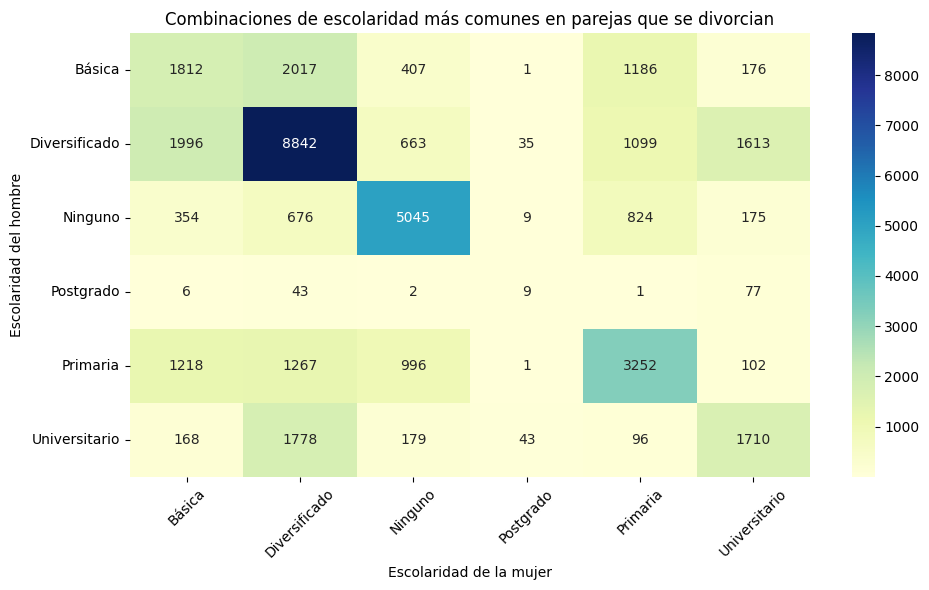

In [38]:
# Crear tabla estilo matriz
tabla = df_valid.pivot_table(index='ESC_HOMBRE', columns='ESC_MUJER', aggfunc='size', fill_value=0)

# Gráfico de calor
plt.figure(figsize=(10, 6))
sns.heatmap(tabla, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Combinaciones de escolaridad más comunes en parejas que se divorcian")
plt.xlabel("Escolaridad de la mujer")
plt.ylabel("Escolaridad del hombre")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Segun el grafico anterior, la mayor parte de las parejes que se divorcian han compartido la misma escolaridad. Esto podría indicar que las personas tienden a emparejarse con alguien de su mismo nivel educativa. Tambien, el grado educativa que tiene mas frecuencia es el diversificado, esto es debido a que diversificado es el nivel educativo mas común en la poblacion en general que llega al matrimonio, por lo tanto tambien en los divorcios. 

En base a estos resultados se puede evidenciar como los conflictos en divorcios no estan necesariamente asociados con una desigualdad educativa, por lo tanto no es un factor que indique que el divorcio sea mas probable.

### ¿Qué grupos étnicos registran más divorcios?

In [42]:
# Contar por grupo étnico del hombre y la mujer
grupo_hombres = merged_df['PUEHOM'].map(PUEHOM).value_counts()
grupo_mujeres = merged_df['PUEMUJ'].map(PUEMUJ).value_counts()

print("Divorcios por grupo étnico (hombres):")
print(grupo_hombres)
print("\nDivorcios por grupo étnico (mujeres):")
print(grupo_mujeres)

Divorcios por grupo étnico (hombres):
PUEHOM
Ignorado            37265
Mestizo / Ladino    32345
Maya                 6044
Otro                  599
Garífuna               26
Xinka                  12
Name: count, dtype: int64

Divorcios por grupo étnico (mujeres):
PUEMUJ
Ignorado            37393
Mestizo / Ladino    32590
Maya                 5589
Otro                  678
Garífuna               25
Xinka                  16
Name: count, dtype: int64


In [40]:
ignorado_hombres = (merged_df['PUEHOM'] == 9).sum() / len(merged_df)
ignorado_mujeres = (merged_df['PUEMUJ'] == 9).sum() / len(merged_df)

print(f"Proporción de 'Ignorado' (hombres): {ignorado_hombres:.2%}")
print(f"Proporción de 'Ignorado' (mujeres): {ignorado_mujeres:.2%}")

Proporción de 'Ignorado' (hombres): 48.85%
Proporción de 'Ignorado' (mujeres): 49.01%


Al analizar los grupos étnicos que registran más divorcios, se observa que el grupo “Mestizo / Ladino” representa la mayor proporción de casos registrados entre quienes sí reportaron esta información, seguido del grupo “Maya”. Estos resultados reflejan, en parte, la distribución poblacional de Guatemala.

Sin embargo, un aspecto relevante a considerar es la alta proporción de datos sin definir: el 48.85% de los registros en el campo “grupo étnico del hombre” y el 49.01% en “grupo étnico de la mujer” están marcados como “Ignorado”. Esto significa que casi la mitad de las observaciones carecen de esta información, lo que limita la capacidad de hacer inferencias concluyentes o representativas sobre la relación entre grupo étnico y divorcios.

### ¿Qué ocupaciones son más comunes entre los hombres y mujeres que se divorcian?

In [ ]:
df_valid = merged_df[(merged_df['CIUOHOM'] != 99) & (merged_df['CIUOMUJ'] != 99)].copy()

df_valid['OCUP_HOMBRE'] = df_valid['CIUOHOM'].map(CIUOHOM)
df_valid['OCUP_MUJER'] = df_valid['CIUOMUJ'].map(CIUOHOM)


ocup_hombres = df_valid['OCUP_HOMBRE'].value_counts().reset_index()
ocup_hombres.columns = ['Ocupación Hombre', 'Cantidad']

ocup_mujeres = df_valid['OCUP_MUJER'].value_counts().reset_index()
ocup_mujeres.columns = ['Ocupación Mujer', 'Cantidad']


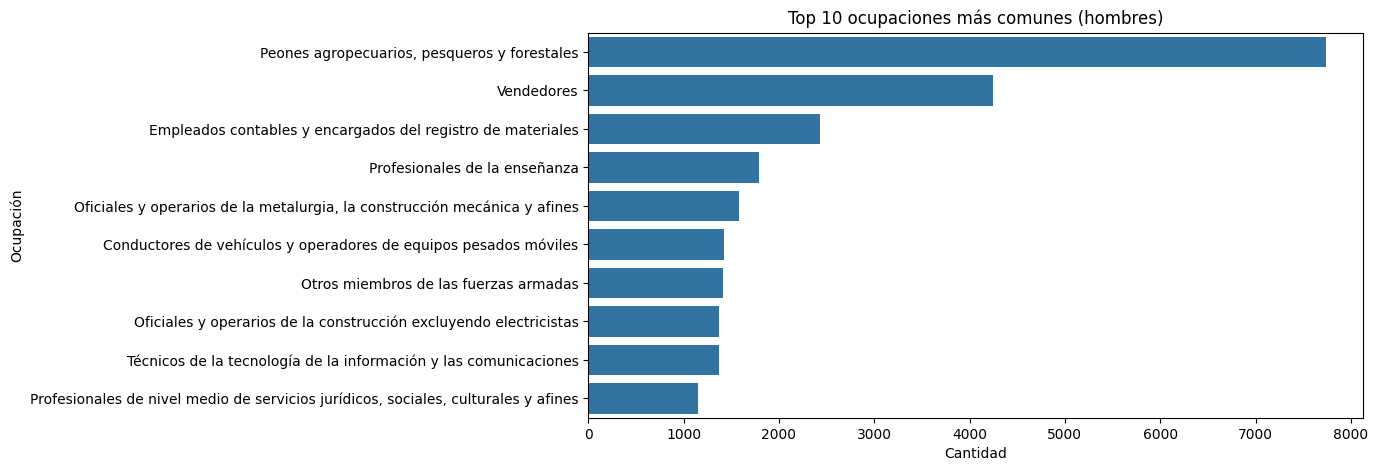

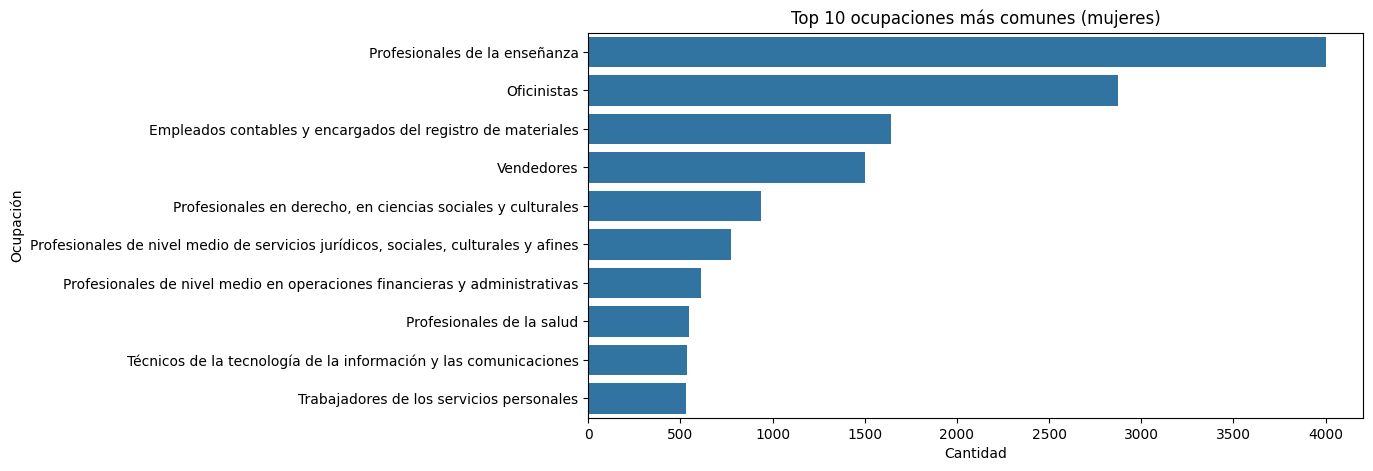

In [47]:
plt.figure(figsize=(10,5))
sns.barplot(data=ocup_hombres.head(10), x='Cantidad', y='Ocupación Hombre')
plt.title('Top 10 ocupaciones más comunes (hombres)')
plt.xlabel("Cantidad")
plt.ylabel("Ocupación")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=ocup_mujeres.head(10), x='Cantidad', y='Ocupación Mujer')
plt.title('Top 10 ocupaciones más comunes (mujeres)')
plt.xlabel("Cantidad")
plt.ylabel("Ocupación")
plt.show()


La ocupacion mas frecuente en los hombres es Peones agropecuarios, pesqueros y forestales, seguido de Vendedores esto puede indicar como muchos de los hombres divorciados pertenecen a los sectores informales, rurales o al sector administrativo. Tambien otros sectores que hacen presencia es la contruccion y fuerzas armadas. Por lo tanto los hombres divorciados tienden a tener ocupaciones fisicas, rurales y en construccion.

En cuanto a las muejeres la ocupacion mas frecuente es profesionales de enseñanza, seguido de oficinista. Esto indica que los sectores educativos, administrativos y de oficina son los mas comunes en este genero. Las mujeres divorciadas suelen tener ocupaciones mas profesionales o tecnicas. Existiendo una mayor concentracion en el sector formal y servicio publico.

### ¿Existe una relación entre la ocupación y el nivel educativo con la edad al divorcio?

In [ ]:
# Agrupar edades por rangos
df_valid["RANGO_EDAD_HOM"] = pd.cut(
    df_valid["EDADHOM"], bins=[15, 25, 35, 45, 55, 65, 100],
    labels=["15-25", "26-35", "36-45", "46-55", "56-65", "65+"]
)

df_valid["RANGO_EDAD_MUJ"] = pd.cut(
    df_valid["EDADMUJ"], bins=[15, 25, 35, 45, 55, 65, 100],
    labels=["15-25", "26-35", "36-45", "46-55", "56-65", "65+"]
)

# Combinar edad, ocupación y escolaridad para hombres
comb_hom = df_valid.groupby(
    ["RANGO_EDAD_HOM", "OCUP_HOMBRE", "ESC_HOMBRE"],
    observed=True # Si no pongo esto sale un error xd
).size().reset_index(name="frecuencia")

# Combinar edad, ocupación y escolaridad para mujeres
comb_muj = df_valid.groupby(
    ["RANGO_EDAD_MUJ", "OCUP_MUJER", "ESC_MUJER"],
    observed=True # Si no pongo esto sale un error xd
).size().reset_index(name="frecuencia")



In [69]:
# Mostrar las combinaciones más frecuentes
top_comb_hom = comb_hom.sort_values("frecuencia", ascending=False).head(10)
top_comb_muj = comb_muj.sort_values("frecuencia", ascending=False).head(10)

display(top_comb_hom)
display(top_comb_muj)


,RANGO_EDAD_HOM,OCUP_HOMBRE,ESC_HOMBRE,frecuencia
175,26-35,"Peones agropecuarios, pesqueros y forestales",Primaria,1066
122,26-35,Empleados contables y encargados del registro ...,Diversificado,722
331,36-45,"Peones agropecuarios, pesqueros y forestales",Primaria,673
242,26-35,Técnicos de la tecnología de la información y ...,Diversificado,558
246,26-35,Vendedores,Diversificado,552
188,26-35,Profesionales de la enseñanza,Diversificado,524
168,26-35,Otros miembros de las fuerzas armadas,Diversificado,509
396,36-45,Vendedores,Diversificado,433
277,36-45,Empleados contables y encargados del registro ...,Diversificado,420
201,26-35,Profesionales de nivel medio de servicios jurí...,Diversificado,402


,RANGO_EDAD_MUJ,OCUP_MUJER,ESC_MUJER,frecuencia
143,26-35,Profesionales de la enseñanza,Diversificado,1229
113,26-35,Oficinistas,Diversificado,793
89,26-35,Empleados contables y encargados del registro ...,Diversificado,541
255,36-45,Profesionales de la enseñanza,Diversificado,488
230,36-45,Oficinistas,Diversificado,359
156,26-35,Profesionales de nivel medio de servicios jurí...,Diversificado,289
39,15-25,Profesionales de la enseñanza,Diversificado,275
161,26-35,Profesionales de nivel medio en operaciones fi...,Diversificado,274
281,36-45,"Profesionales en derecho, en ciencias sociales...",Universitario,257
172,26-35,"Profesionales en derecho, en ciencias sociales...",Universitario,256


Por lo que se puede observar si existe una realcion clara entre las tres varibales observadas: edad, ocupacion y nivel educativo. La mayoria de los divorcios ocurren de 26 - 35 años que es donde mas se divorcian las mujeres. Otra observacion es que las ocupaciones con salarios bajos y nivel educativo bajo son mas frecuentes a tener un divorcio. En ambos casos nivel Diversificado es el mas común.

### ¿La ocupación de la mujer afecta la frecuencia de divorcio en ciertas regiones?

In [ ]:
df_valid["DEPREG_NOMBRE"] = df_valid["DEPREG"].map(DEPREG)
df_valid["OCUP_MUJER_NOMBRE"] = df_valid["CIUOMUJ"].map(CIUOMUJ)
frecuencia_ocupacion_region = df_valid.groupby(
    ["DEPREG_NOMBRE", "OCUP_MUJER_NOMBRE"]
).size().reset_index(name="frecuencia")
frecuencia_ocupacion_region.sort_values(by="frecuencia", ascending=False).head(10)


,DEPREG_NOMBRE,OCUP_MUJER_NOMBRE,frecuencia
139,Guatemala,Oficinistas,800
146,Guatemala,Profesionales de la enseñanza,604
158,Guatemala,Vendedores,510
132,Guatemala,Empleados contables y encargados del registro ...,455
152,Guatemala,"Profesionales en derecho, en ciencias sociales...",441
284,Quetzaltenango,Profesionales de la enseñanza,236
154,Guatemala,Suboficiales de las fuerzas armadas,220
157,Guatemala,Técnicos de la tecnología de la información y ...,212
134,Guatemala,Especialistas en organización de la administra...,207
149,Guatemala,Profesionales de nivel medio de servicios jurí...,198


C:\Users\Gerax\AppData\Local\Temp\ipykernel_13780\1301098587.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


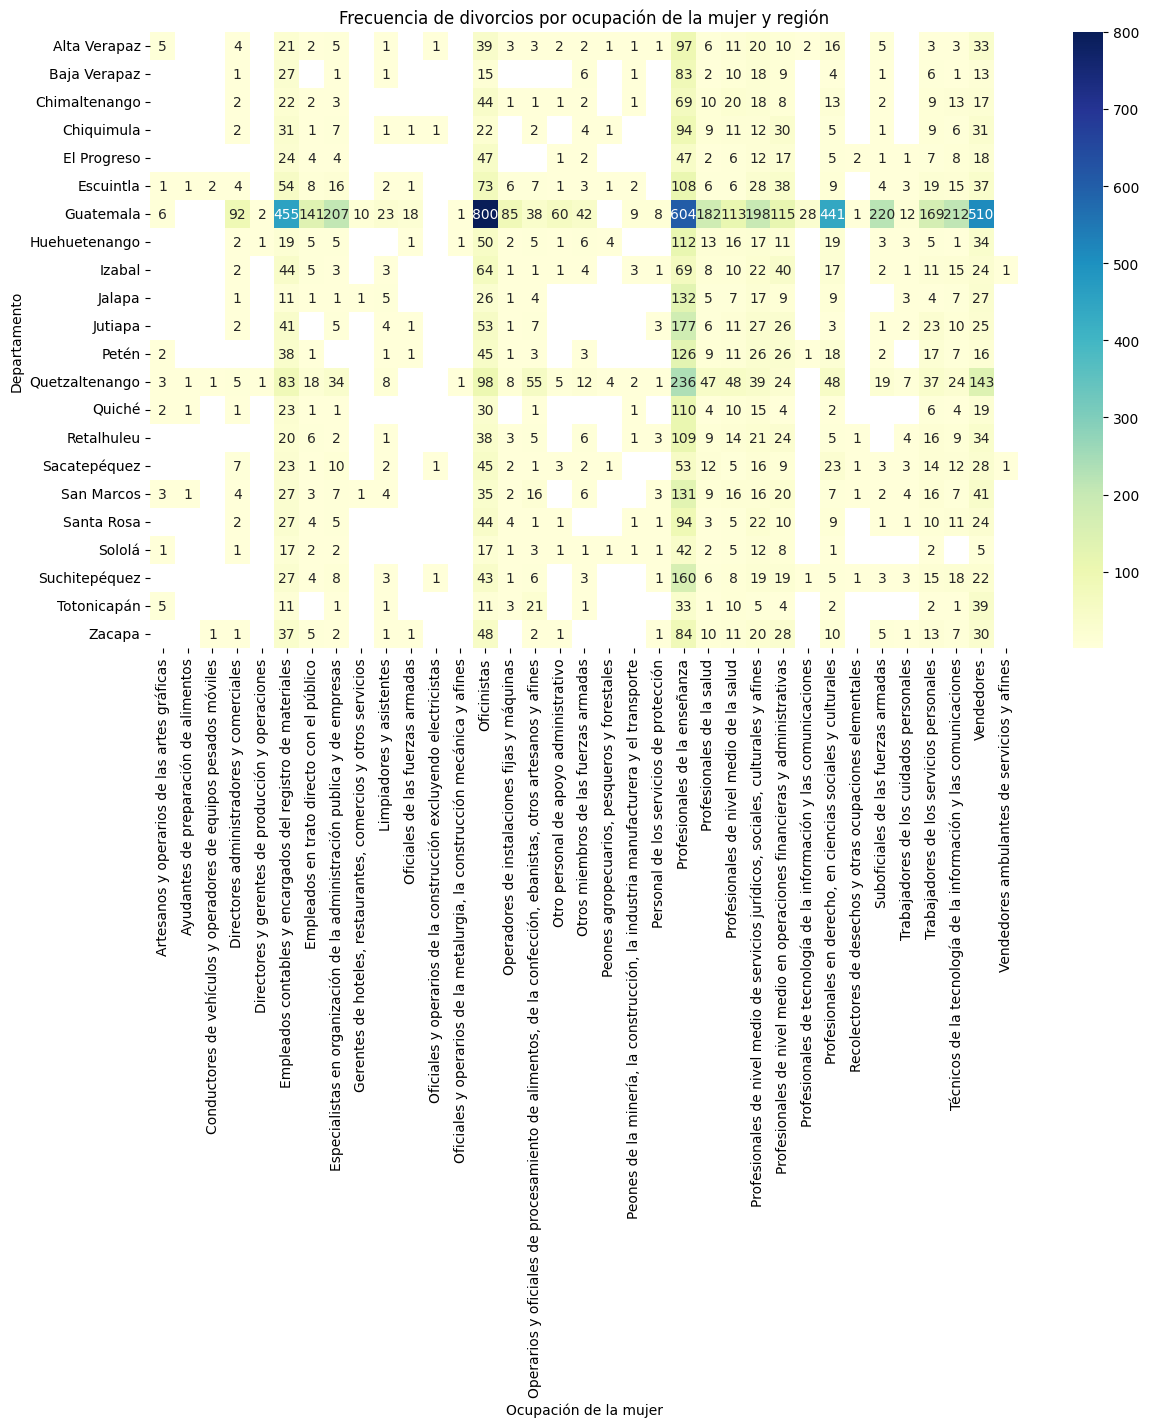

In [52]:
pivot = frecuencia_ocupacion_region.pivot(
    index="DEPREG_NOMBRE", columns="OCUP_MUJER_NOMBRE", values="frecuencia"
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Frecuencia de divorcios por ocupación de la mujer y región")
plt.xlabel("Ocupación de la mujer")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()


Aunque Anteriormente fue respondida esta pregunta, aqui hay una vision mas amplia incluyendo los diferentes departamentos de Guatemala. Se puede observar como en muejeres la ocupacion con mas divorcios a lo largo de los departamentos es Profesionales de eneseñanza. Seguido de esto estaria en el oficio de Oficinasta. Se puede observar que en todos los deparatemento se sigue teniendo el mismo patron pero escalado a la cantidad de personas de la region.

### ¿La ocupación de los hombres afecta la frecuencia de divorcio en ciertas regiones?

In [57]:
df_valid["DEPREG_NOMBRE"] = df_valid["DEPREG"].map(DEPREG)
df_valid["OCUP_HOMBRE_NOMBRE"] = df_valid["CIUOHOM"].map(CIUOHOM)

frecuencia_ocupacion_region_hombre = df_valid.groupby(
    ["DEPREG_NOMBRE", "OCUP_HOMBRE_NOMBRE"]
).size().reset_index(name="frecuencia")

frecuencia_ocupacion_region_hombre.sort_values(by="frecuencia", ascending=False).head(10)



,DEPREG_NOMBRE,OCUP_HOMBRE_NOMBRE,frecuencia
214,Guatemala,Vendedores,1153
183,Guatemala,Empleados contables y encargados del registro ...,706
213,Guatemala,Técnicos de la tecnología de la información y ...,548
382,Quetzaltenango,"Peones agropecuarios, pesqueros y forestales",511
506,San Marcos,"Peones agropecuarios, pesqueros y forestales",425
197,Guatemala,"Peones agropecuarios, pesqueros y forestales",422
208,Guatemala,Suboficiales de las fuerzas armadas,415
398,Quetzaltenango,Vendedores,362
180,Guatemala,Conductores de vehículos y operadores de equip...,358
231,Huehuetenango,"Peones agropecuarios, pesqueros y forestales",354


C:\Users\Gerax\AppData\Local\Temp\ipykernel_13780\3724260074.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


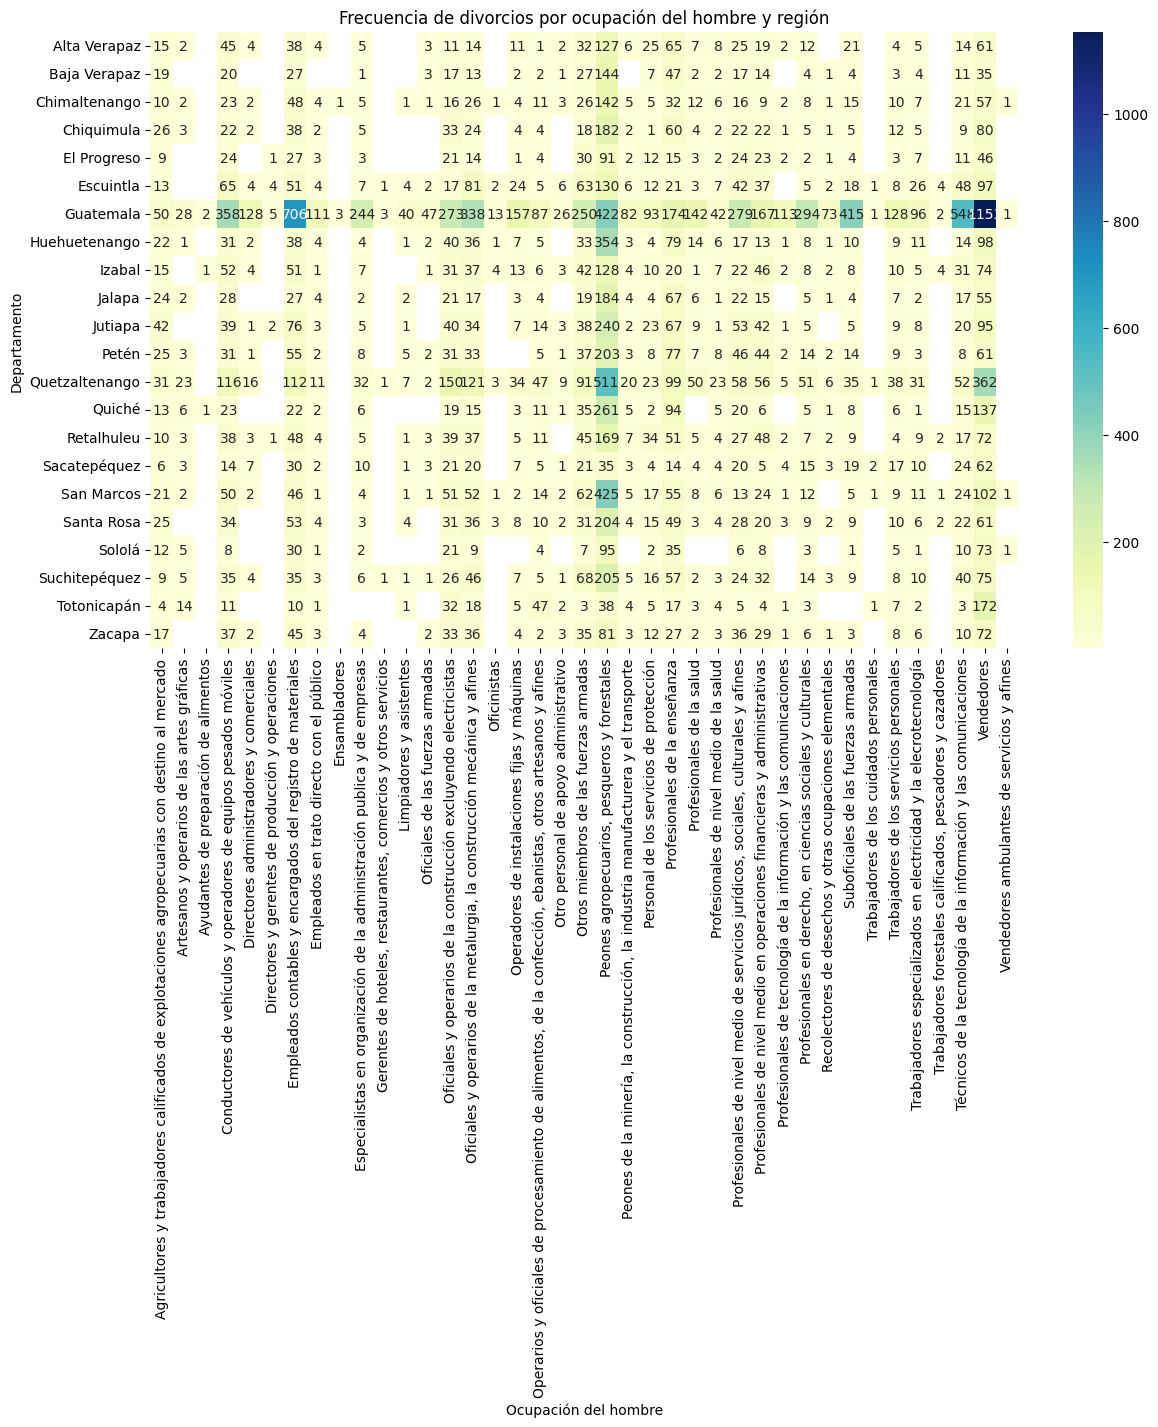

In [ ]:
# Crear la tabla dinámica
pivot_hombres = frecuencia_ocupacion_region_hombre.pivot(
    index="DEPREG_NOMBRE", 
    columns="OCUP_HOMBRE_NOMBRE", 
    values="frecuencia"
)

# Graficar el heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_hombres, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Frecuencia de divorcios por ocupación del hombre y región")
plt.xlabel("Ocupación del hombre")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()


De igual forma que las mujeres, esta pregunta fue parcialmente respondida con anterioridad pero esta vez viendo una vision mas amplia al rededor de todos los departamentos. De igual manera, los hombres siguen los mismos patrones que en los datos generales, pero aqui se puede observar como en Guatemala y Quetzaltenango es donde mas se evidencian estos datos.

### ¿Las parejas con mayor diferencia de edad se divorcian más?

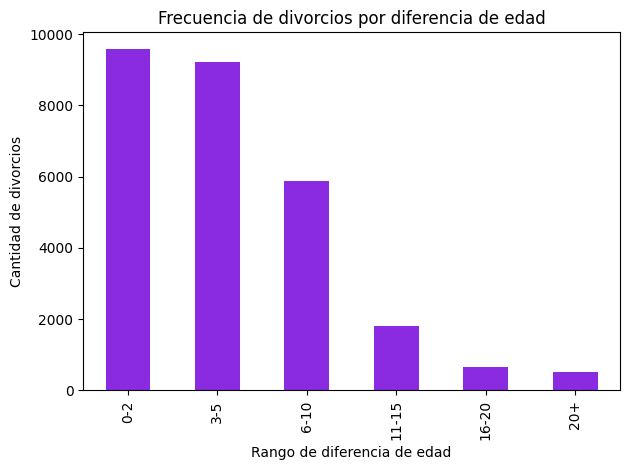

In [61]:
# Crear columna con la diferencia de edad (valor absoluto)
df_valid["DIF_EDAD"] = abs(df_valid["EDADHOM"] - df_valid["EDADMUJ"])

# Agrupar por rango de diferencia de edad
df_valid["RANGO_DIF_EDAD"] = pd.cut(
    df_valid["DIF_EDAD"], 
    bins=[0, 2, 5, 10, 15, 20, 100],
    labels=["0-2", "3-5", "6-10", "11-15", "16-20", "20+"]
)

# Contar divorcios por cada rango de diferencia
conteo_dif = df_valid["RANGO_DIF_EDAD"].value_counts().sort_index()

# Graficar
import matplotlib.pyplot as plt
conteo_dif.plot(kind='bar', color='blueviolet')
plt.title("Frecuencia de divorcios por diferencia de edad")
plt.xlabel("Rango de diferencia de edad")
plt.ylabel("Cantidad de divorcios")
plt.tight_layout()
plt.show()


Al analizar si tener una mayor diferencia de edad provoca mas divorcios, se logro encontrar que la mayoria de los divorcios ocurren cuando la diferencia de edad es relativamente baja. Tomando en cuenta las primeras dos columnas, el rango de mas frecuencia en la diferencia de edad es de 0 a 5 años. Por lo que, no, las parejas con mayor diferencia de edad tienden a no separarse con tanta frecuencia, aun asi, siempre existe el riesgo de que pase.

## Análisis por clustering

# Hallazgos y conclusiones